In [1]:
# Define experiment parameters
year = "200506"
target_col = "has_occ"  # 'white_collar', 'blue_collar', 'has_occ'
sample_weight_col = 'women_weight'

In [2]:
# Define resource utilization parameters
random_state = 42
n_jobs_clf = 16
n_jobs_cv = 4
cv_folds = 5

In [3]:
import numpy as np
np.random.seed(random_state)

import pandas as pd
pd.set_option('display.max_columns', 500)

import matplotlib.pylab as pl

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.utils.class_weight import compute_class_weight

import lightgbm
from lightgbm import LGBMClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import shap

import pickle
from joblib import dump, load

---

# Prepare Dataset

In [4]:
# Load dataset
dataset = pd.read_csv(f"data/women_work_data_{year}.csv")
print("Loaded dataset: ", dataset.shape)
dataset.head()

Loaded dataset:  (116417, 25)


case_id_str country_code  cluster_no  hh_no  line_no  \
0     28  1   1  2          IA5       28001      1        2   
1     28  1   1  4          IA5       28001      1        4   
2     28  1   2  2          IA5       28001      2        2   
3     28  1   2  5          IA5       28001      2        5   
4     28  1   4  3          IA5       28001      4        3   

                 state hh_religion                 caste  occupation  no_occ  \
0  [ap] andhra pradesh       hindu       scheduled tribe           0       1   
1  [ap] andhra pradesh       hindu       scheduled tribe           5       0   
2  [ap] andhra pradesh       hindu  other backward class           5       0   
3  [ap] andhra pradesh       hindu  other backward class           5       0   
4  [ap] andhra pradesh       hindu  other backward class           8       0   

   white_collar  blue_collar  has_occ  women_weight  urban  women_anemic  \
0             0            0        0      2.474583      0           NaN   
1             0            1        1      2.474583      0           0.0   
2             0            1        1      2.474583      0           0.0   
3             0            1        1      2.474583      0           1.0   
4             0            1        1      2.474583      0           0.0   

   total_children  obese_female  age  years_edu  wealth_index  hh_members  \
0               4           NaN   47          0             2           6   
1               2           0.0   23          2             2           6   
2               1           0.0   20          0             2           5   
3               0           0.0   40          0             2           5   
4               2           0.0   31          7             3           5   

   no_children_below5  freq_tv  year  
0                   2      0.0  2005  
1                   2      3.0  2005  
2                   0      3.0  2005  
3                   0      2.0  2005  
4                   0      3.0  2005

In [5]:
# See distribution of target values
print("Target column distribution:\n", dataset[target_col].value_counts(dropna=False))

Target column distribution:
 0    68759
1    47658
Name: has_occ, dtype: int64


In [6]:
# Drop samples where the target is missing
dataset.dropna(axis=0, subset=[target_col, sample_weight_col], inplace=True)
print("Drop missing targets: ", dataset.shape)

Drop missing targets:  (116417, 25)


In [7]:
# Drop samples where age < 21
dataset = dataset[dataset['age'] >= 21]
print("Drop under-21 samples: ", dataset.shape)

Drop under-21 samples:  (89163, 25)


In [8]:
# See new distribution of target values
print("Target column distribution:\n", dataset[target_col].value_counts(dropna=False))

Target column distribution:
 0    49779
1    39384
Name: has_occ, dtype: int64


In [9]:
# Post-processing

# Group SC/ST castes together
dataset['caste'][dataset['caste'] == 'scheduled caste'] = 'sc/st'
dataset['caste'][dataset['caste'] == 'scheduled tribe'] = 'sc/st'
if year == "200506":
    dataset['caste'][dataset['caste'] == '9'] = "don\'t know"

# Fix naming for General caste
dataset['caste'][dataset['caste'] == 'none of above'] = 'general'

if year == "201516":
    # Convert wealth index from str to int values
    wi_dict = {'poorest': 0, 'poorer': 1, 'middle': 2, 'richer': 3, 'richest': 4}
    dataset['wealth_index'] = [wi_dict[wi] for wi in dataset['wealth_index']]

/home/chaitanya/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/chaitanya/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/chaitanya/miniconda3/envs/tf_gpu/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [10]:
# Define feature columns
x_cols_categorical = ['state', 'hh_religion', 'caste']
x_cols_binary = ['urban', 'women_anemic', 'obese_female']
x_cols_numeric = ['age', 'years_edu', 'wealth_index', 'hh_members', 'no_children_below5', 'total_children', 'freq_tv']
x_cols = x_cols_categorical + x_cols_binary + x_cols_numeric
print("Feature columns:\n", x_cols)

Feature columns:
 ['state', 'hh_religion', 'caste', 'urban', 'women_anemic', 'obese_female', 'age', 'years_edu', 'wealth_index', 'hh_members', 'no_children_below5', 'total_children', 'freq_tv']


In [11]:
# Drop samples with missing values in feature columns
dataset.dropna(axis=0, subset=x_cols, inplace=True)
print("Drop missing feature value rows: ", dataset.shape)

Drop missing feature value rows:  (77762, 25)


In [12]:
# Separate target column
targets = dataset[target_col]
# Separate sampling weight column
sample_weights = dataset[sample_weight_col]
# Drop columns which are not part of features
dataset.drop(columns=[col for col in dataset.columns if col not in x_cols], axis=1, inplace=True)
print("Drop extra columns: ", dataset.shape)

Drop extra columns:  (77762, 13)


In [13]:
# Obtain one-hot encodings for the caste column
dataset = pd.get_dummies(dataset, columns=['caste'])
x_cols_categorical.remove('caste')  # Remove 'caste' from categorical variables list
print("Caste to one-hot: ", dataset.shape)

Caste to one-hot:  (77762, 16)


In [14]:
dataset_display = dataset.copy()
print("Create copy for visualization: ", dataset_display.shape)
dataset_display.head()

Create copy for visualization:  (77762, 16)


state hh_religion  urban  women_anemic  total_children  \
1  [ap] andhra pradesh       hindu      0           0.0               2   
3  [ap] andhra pradesh       hindu      0           1.0               0   
4  [ap] andhra pradesh       hindu      0           0.0               2   
5  [ap] andhra pradesh      muslim      0           0.0               2   
6  [ap] andhra pradesh       hindu      0           0.0               2   

   obese_female  age  years_edu  wealth_index  hh_members  no_children_below5  \
1           0.0   23          2             2           6                   2   
3           0.0   40          0             2           5                   0   
4           0.0   31          7             3           5                   0   
5           0.0   22          0             3           7                   2   
6           1.0   25          6             3           3                   0   

   freq_tv  caste_don't know  caste_general  caste_other backward class  \
1      3.0                 0              0                           0   
3      2.0                 0              0                           1   
4      3.0                 0              0                           1   
5      3.0                 0              0                           1   
6      3.0                 0              1                           0   

   caste_sc/st  
1            1  
3            0  
4            0  
5            0  
6            0

In [15]:
# Obtain integer encodings for other categorical features
for col in x_cols_categorical:
    dataset[col] = pd.factorize(dataset[col])[0]
print("Categoricals to int encodings: ", dataset.shape)

Categoricals to int encodings:  (77762, 16)


In [16]:
dataset.head()

state  hh_religion  urban  women_anemic  total_children  obese_female  age  \
1      0            0      0           0.0               2           0.0   23   
3      0            0      0           1.0               0           0.0   40   
4      0            0      0           0.0               2           0.0   31   
5      0            1      0           0.0               2           0.0   22   
6      0            0      0           0.0               2           1.0   25   

   years_edu  wealth_index  hh_members  no_children_below5  freq_tv  \
1          2             2           6                   2      3.0   
3          0             2           5                   0      2.0   
4          7             3           5                   0      3.0   
5          0             3           7                   2      3.0   
6          6             3           3                   0      3.0   

   caste_don't know  caste_general  caste_other backward class  caste_sc/st  
1                 0              0                           0            1  
3                 0              0                           1            0  
4                 0              0                           1            0  
5                 0              0                           1            0  
6                 0              1                           0            0

In [17]:
# Create Training, Validation and Test sets
X_train, X_test, Y_train, Y_test, W_train, W_test = train_test_split(dataset, targets, sample_weights, test_size=0.05, random_state=random_state, stratify=targets)
# X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(X_train, Y_train, W_train, test_size=0.1)
print("Training set: ", X_train.shape, Y_train.shape, W_train.shape)
# print("Validation set: ", X_val.shape, Y_val.shape, W_val.shape)
print("Test set: ", X_test.shape, Y_test.shape, W_test.shape)
train_cw = compute_class_weight("balanced", classes=np.unique(Y_train), y=Y_train)
print("Class weights: ", train_cw)

Training set:  (73873, 16) (73873,) (73873,)
Test set:  (3889, 16) (3889,) (3889,)
Class weights:  [0.90150591 1.12265585]


---

# Build LightGBM Classifier

In [18]:
# # Define LightGBM Classifier
# model = LGBMClassifier(boosting_type='gbdt', 
#                        feature_fraction=0.8,  
#                        learning_rate=0.01,
#                        max_bins=64,
#                        max_depth=-1,
#                        min_child_weight=0.001,
#                        min_data_in_leaf=50,
#                        min_split_gain=0.0,
#                        num_iterations=1000,
#                        num_leaves=64,
#                        reg_alpha=0,
#                        reg_lambda=1,
#                        subsample_for_bin=200000,
#                        is_unbalance=True,
#                        random_state=random_state, 
#                        n_jobs=n_jobs_clf, 
#                        silent=True, 
#                        importance_type='split')

In [19]:
# # Fit model on training set
# model.fit(X_train, Y_train, sample_weight=W_train.values, 
#           #categorical_feature=x_cols_categorical,
#           categorical_feature=[])

In [20]:
# # Make predictions on Test set
# predictions = model.predict(X_test)
# print(accuracy_score(Y_test, predictions))
# print(f1_score(Y_test, predictions))
# print(confusion_matrix(Y_test, predictions))
# print(classification_report(Y_test, predictions))

In [21]:
# # Save trained model
# dump(model, f'models/{target_col}-{year}-model.joblib')
# del model

### Hyperparameter Search

In [22]:
# # Define hyperparameter grid
# param_grid = {
#     'num_leaves': [8, 32, 64],
#     'min_data_in_leaf': [10, 20, 50],
#     'max_depth': [-1], 
#     'learning_rate': [0.01, 0.1], 
#     'num_iterations': [1000, 3000, 5000], 
#     'subsample_for_bin': [200000],
#     'min_split_gain': [0.0], 
#     'min_child_weight': [0.001],
#     'feature_fraction': [0.8, 1.0], 
#     'reg_alpha': [0], 
#     'reg_lambda': [0, 1],
#     'max_bin': [64, 128, 255]
# }

In [23]:
# # Define LightGBM Classifier
# clf = LGBMClassifier(boosting_type='gbdt',
#                      objective='binary', 
#                      is_unbalance=True,
#                      random_state=random_state,
#                      n_jobs=n_jobs_clf, 
#                      silent=True, 
#                      importance_type='split')

# # Define K-fold cross validation splitter
# kfold = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=random_state)

# # Perform grid search
# model = GridSearchCV(clf, param_grid=param_grid, scoring='f1', n_jobs=n_jobs_cv, cv=kfold, refit=True, verbose=3)
# model.fit(X_train, Y_train, 
#           sample_weight=W_train.values, 
#           #categorical_feature=x_cols_categorical,
#           categorical_feature=[])

# print('\n All results:')
# print(model.cv_results_)
# print('\n Best estimator:')
# print(model.best_estimator_)
# print('\n Best hyperparameters:')
# print(model.best_params_)

In [24]:
# # Make predictions on Test set
# predictions = model.predict(X_test)
# print(accuracy_score(Y_test, predictions))
# print(f1_score(Y_test, predictions, average='micro'))
# print(confusion_matrix(Y_test, predictions))
# print(classification_report(Y_test, predictions))

In [25]:
# # Save trained model
# dump(model, f'models/{target_col}-{year}-gridsearch.joblib')
# del model

---

# Load LightGBM Classifier

In [26]:
model = load(f'models/{target_col}-{year}-model.joblib')
# model = load(f'models/{target_col}-{year}-gridsearch.joblib').best_estimator_

In [27]:
# Sanity check: Make predictions on Test set
predictions = model.predict(X_test)
print(accuracy_score(Y_test, predictions))
print(f1_score(Y_test, predictions))
print(confusion_matrix(Y_test, predictions))
print(classification_report(Y_test, predictions))

0.7012085368989457
0.6662837449741528
[[1567  590]
 [ 572 1160]]
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      2157
           1       0.66      0.67      0.67      1732

   micro avg       0.70      0.70      0.70      3889
   macro avg       0.70      0.70      0.70      3889
weighted avg       0.70      0.70      0.70      3889



In [28]:
# Overfitting check: Make predictions on Train set
predictions = model.predict(X_train)
print(accuracy_score(Y_train, predictions))
print(f1_score(Y_train, predictions))
print(confusion_matrix(Y_train, predictions))
print(classification_report(Y_train, predictions))

0.7224019601207478
0.6896123749413491
[[30585 10387]
 [10120 22781]]
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     40972
           1       0.69      0.69      0.69     32901

   micro avg       0.72      0.72      0.72     73873
   macro avg       0.72      0.72      0.72     73873
weighted avg       0.72      0.72      0.72     73873



---

# Visualizations/Explainations
- Reference: https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
- Github: https://github.com/slundberg/shap

**Note that these plot just explain how the XGBoost model works, not nessecarily how reality works.** Since the XGBoost model is trained from observational data, it is not nessecarily a causal model, and so just because changing a factor makes the model's prediction of winning go up, does not always mean it will raise your actual chances.

In [29]:
# print the JS visualization code to the notebook
shap.initjs()

### What makes a measure of feature importance good or bad?

1. Consistency: Whenever we change a model such that it relies more on a feature, then the attributed importance for that feature should not decrease.
2. Accuracy. The sum of all the feature importances should sum up to the total importance of the model. (For example if importance is measured by the R² value then the attribution to each feature should sum to the R² of the full model)

**If consistency fails to hold, then we can’t compare the attributed feature importances between any two models**, because then having a higher assigned attribution doesn’t mean the model actually relies more on that feature.

**If accuracy fails to hold then we don’t know how the attributions of each feature combine to represent the output of the whole model.** We can’t just normalize the attributions after the method is done since this might break the consistency of the method.

### Using Tree SHAP for interpretting the model 

In [30]:
explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(dataset)
shap_values = pickle.load(open(f'res/{target_col}-{year}-shapvals.obj', 'rb'))

In [31]:
# Visualize a single prediction
shap.force_plot(explainer.expected_value, shap_values[0,:], dataset_display.iloc[0,:])

The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. **Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.**

If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [32]:
# Visualize many predictions
subsample = np.random.choice(len(dataset), 1000)  # Take random sub-sample
shap.force_plot(explainer.expected_value, shap_values[subsample,:], dataset_display.iloc[subsample,:])

## Summary Plots

In [33]:
for col, sv in zip(dataset.columns, np.abs(shap_values).mean(0)):
    print(f"{col} - {sv}")

state - 0.3575478548127349
hh_religion - 0.09760334935141947
urban - 0.15935365566509874
women_anemic - 0.009291346113474614
total_children - 0.09292482977588332
obese_female - 0.08548892590588891
age - 0.1713514522117009
years_edu - 0.2325260368363705
wealth_index - 0.451064453095569
hh_members - 0.06716296856801542
no_children_below5 - 0.15896281510023197
freq_tv - 0.09878840659883825
caste_don't know - 0.0016005658868862907
caste_general - 0.16377405206918433
caste_other backward class - 0.009318146600056629
caste_sc/st - 0.0634103567754422


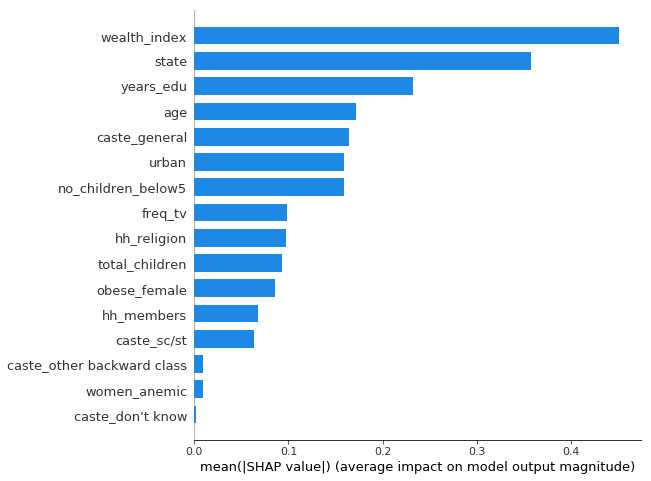

In [34]:
shap.summary_plot(shap_values, dataset, plot_type="bar")

The above figure shows the global mean(|Tree SHAP|) method applied to our model. 

**The x-axis is essentially the average magnitude change in model output when a feature is “hidden” from the model (for this model the output has log-odds units).** “Hidden” means integrating the variable out of the model. Since the impact of hiding a feature changes depending on what other features are also hidden, Shapley values are used to enforce consistency and accuracy.

However, since we now have individualized explanations for every person in our dataset, to get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low):

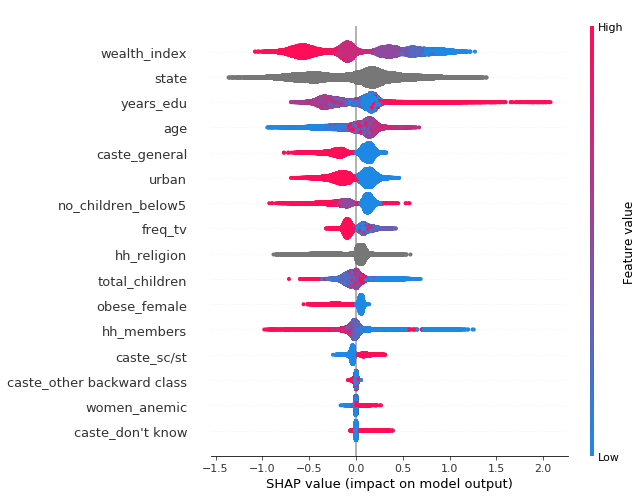

In [35]:
shap.summary_plot(shap_values, dataset_display)

- Every person has one dot on each row. 
- **The x position of the dot is the impact of that feature on the model’s prediction for the person.**
- **The color of the dot represents the value of that feature for the customer.** Categorical variables are colored grey.
- Dots that don’t fit on the row pile up to show density (since our dataset is large). 
- Since the XGBoost model has a logistic loss the x-axis has units of log-odds (Tree SHAP explains the change in the margin output of the model).

**How to use this**: We can make analysis similar to [the blog post](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27) for interpretting our models.

---

### SHAP Dependence Plots

Next, to understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. SHAP dependence plots show the effect of a single feature across the whole dataset. **They plot a feature's value vs. the SHAP value of that feature across many samples.** 

SHAP dependence plots are similar to partial dependence plots, but account for the interaction effects present in the features, and are only defined in regions of the input space supported by data. The vertical dispersion of SHAP values at a single feature value is driven by interaction effects, and another feature is chosen for coloring to highlight possible interactions. **One the benefits of SHAP dependence plots over traditional partial dependence plots is this ability to distigush between between models with and without interaction terms. In other words, SHAP dependence plots give an idea of the magnitude of the interaction terms through the vertical variance of the scatter plot at a given feature value.**

Good example of using Dependency Plots: https://slundberg.github.io/shap/notebooks/League%20of%20Legends%20Win%20Prediction%20with%20XGBoost.html

#### Plots for 'age'


Feature: age, Interaction Feature: age


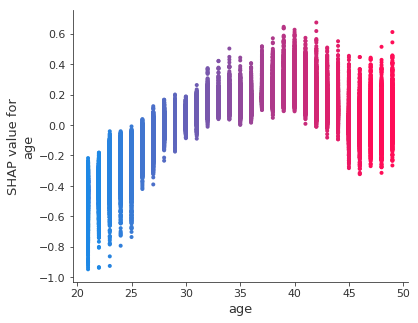


Feature: age, Interaction Feature: urban


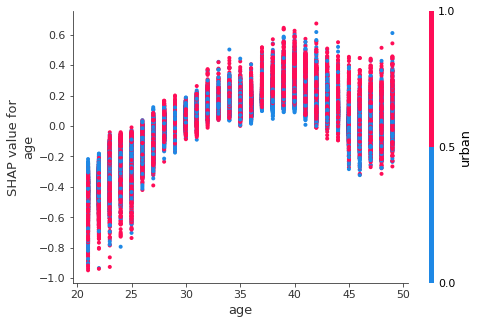


Feature: age, Interaction Feature: caste_sc/st


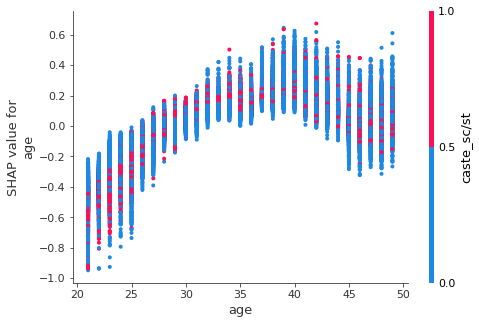


Feature: age, Interaction Feature: caste_general


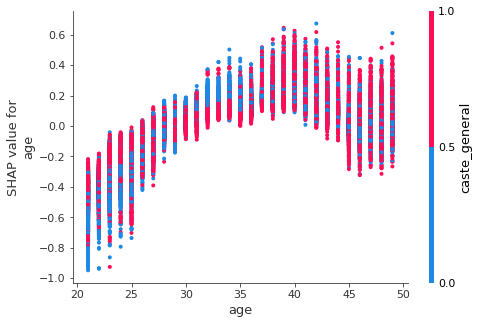


Feature: age, Interaction Feature: wealth_index


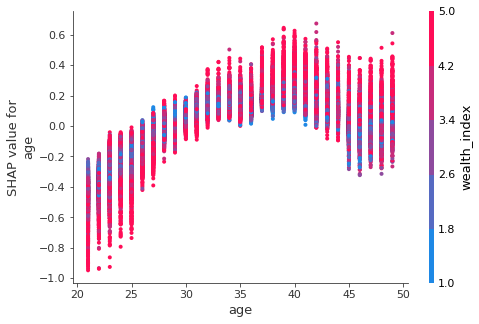


Feature: age, Interaction Feature: years_edu


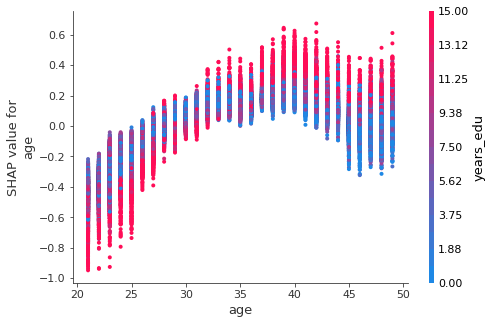


Feature: age, Interaction Feature: no_children_below5


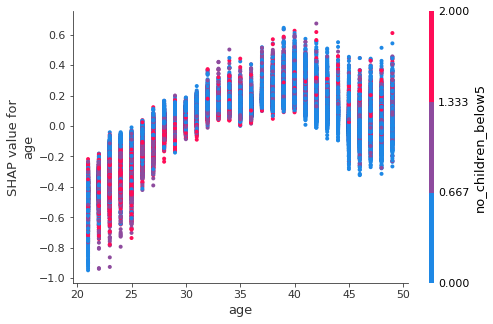


Feature: age, Interaction Feature: total_children


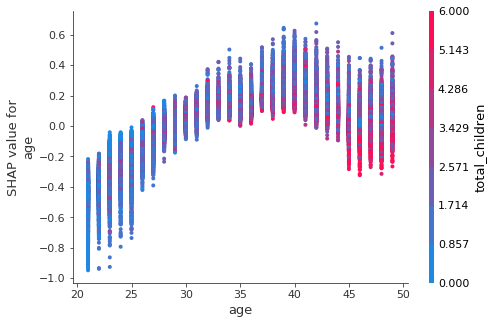


Feature: hh_religion, Interaction Feature: age


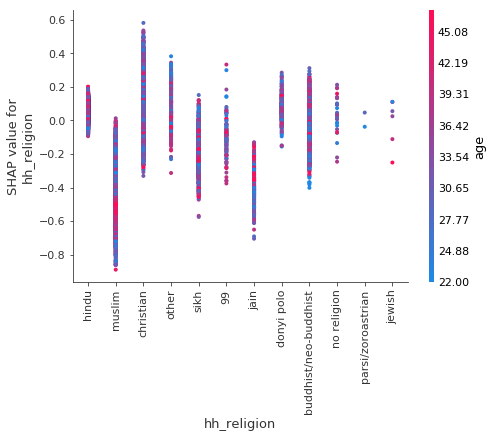


Feature: state, Interaction Feature: age


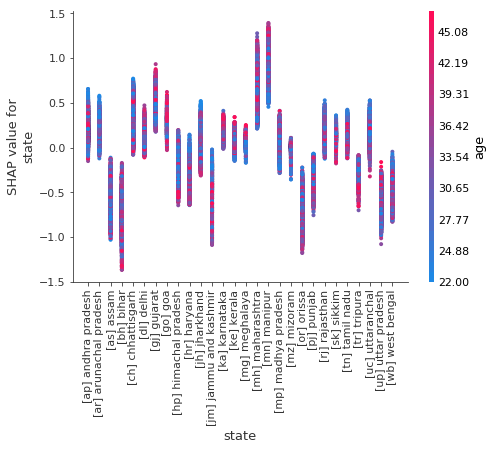

In [36]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('age', 'age'),
         ('age', 'urban'),
         ('age', 'caste_sc/st'),
         ('age', 'caste_general'),
         ('age', 'wealth_index'),
         ('age', 'years_edu'),
         ('age', 'no_children_below5'),
         ('age', 'total_children'),
         ('hh_religion', 'age'),
         ('state', 'age')]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'wealth_index'


Feature: wealth_index, Interaction Feature: wealth_index


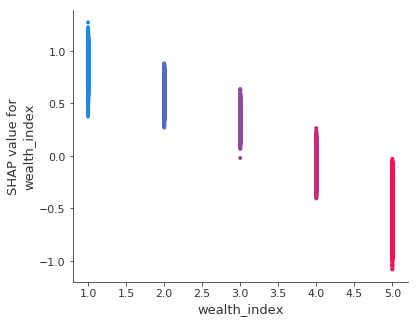


Feature: wealth_index, Interaction Feature: age


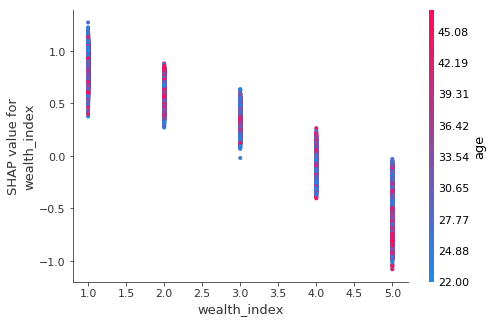


Feature: wealth_index, Interaction Feature: urban


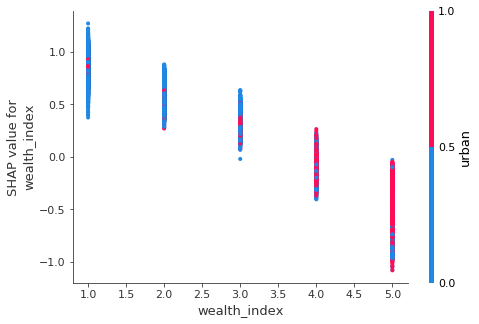


Feature: wealth_index, Interaction Feature: caste_sc/st


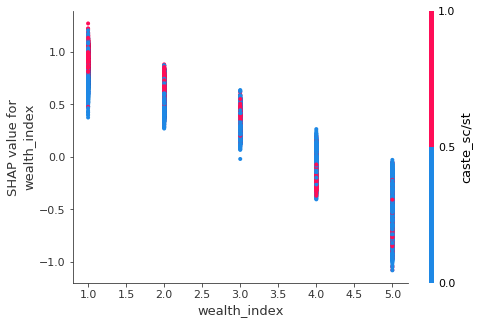


Feature: wealth_index, Interaction Feature: caste_general


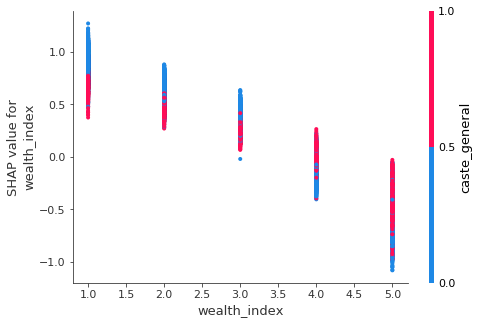


Feature: wealth_index, Interaction Feature: years_edu


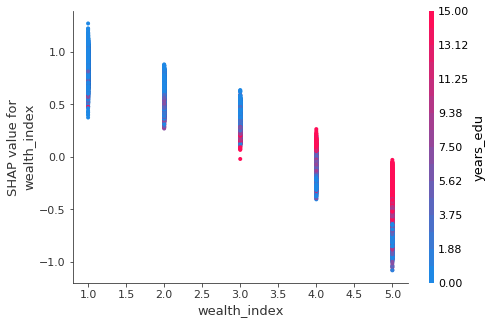


Feature: wealth_index, Interaction Feature: no_children_below5


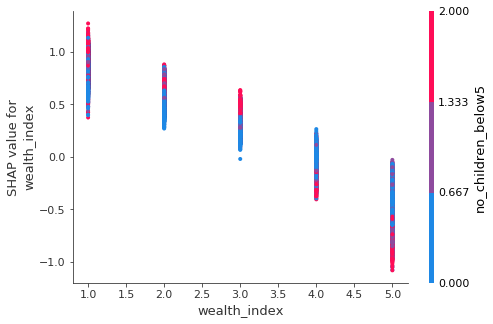


Feature: wealth_index, Interaction Feature: total_children


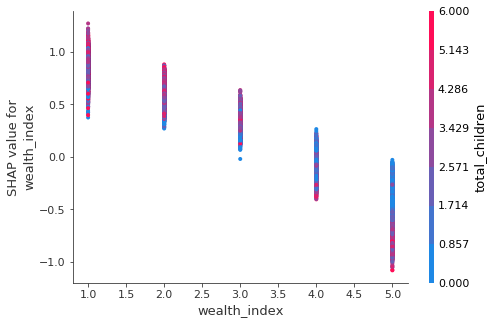


Feature: hh_religion, Interaction Feature: wealth_index


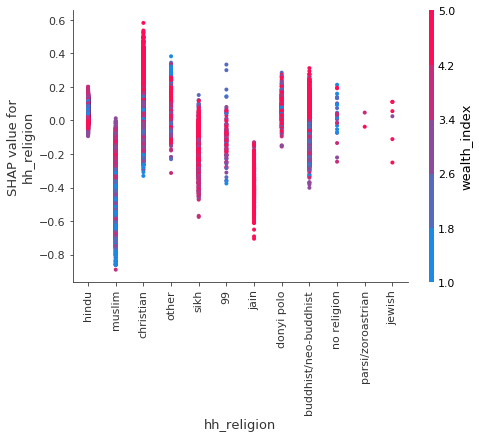


Feature: state, Interaction Feature: wealth_index


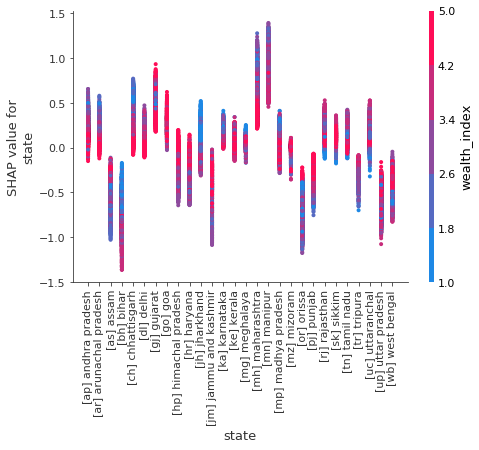

In [37]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('wealth_index', 'wealth_index'),
         ('wealth_index', 'age'), 
         ('wealth_index', 'urban'),
         ('wealth_index', 'caste_sc/st'),
         ('wealth_index', 'caste_general'),
         ('wealth_index', 'years_edu'),
         ('wealth_index', 'no_children_below5'),
         ('wealth_index', 'total_children'),
         ('hh_religion', 'wealth_index'),
         ('state', 'wealth_index')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'years_edu'


Feature: years_edu, Interaction Feature: years_edu


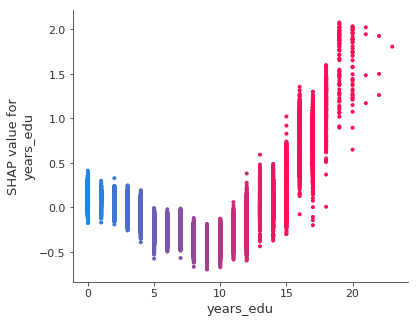


Feature: years_edu, Interaction Feature: age


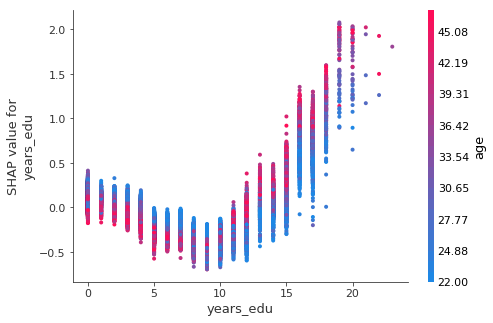


Feature: years_edu, Interaction Feature: urban


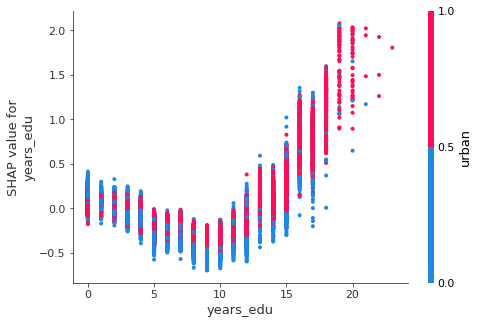


Feature: years_edu, Interaction Feature: caste_sc/st


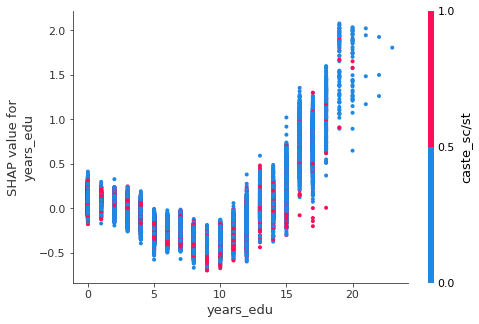


Feature: years_edu, Interaction Feature: caste_general


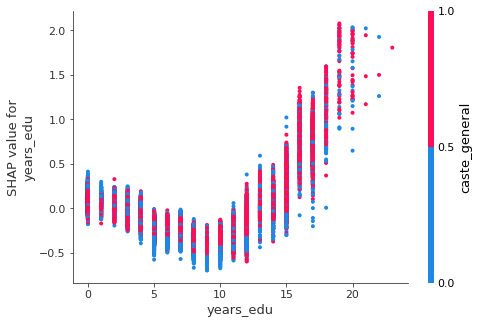


Feature: years_edu, Interaction Feature: wealth_index


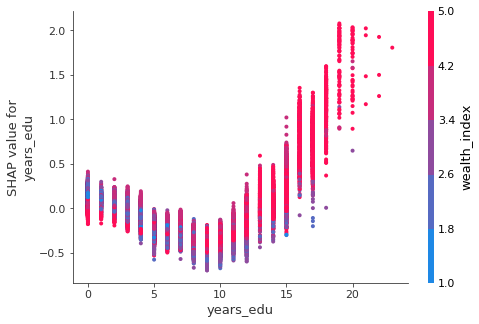


Feature: years_edu, Interaction Feature: no_children_below5


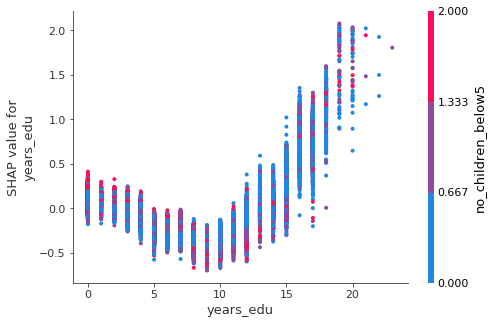


Feature: years_edu, Interaction Feature: total_children


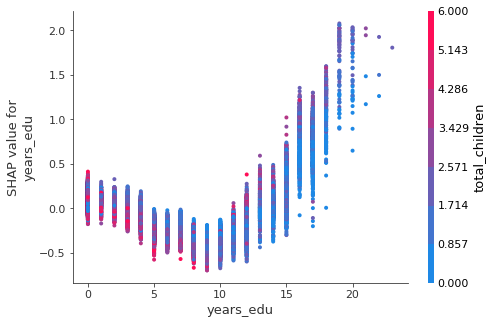


Feature: hh_religion, Interaction Feature: years_edu


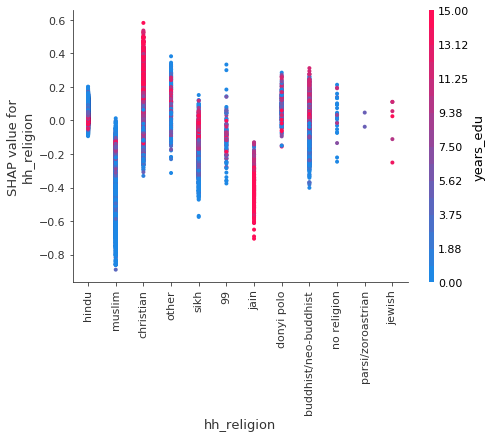


Feature: state, Interaction Feature: years_edu


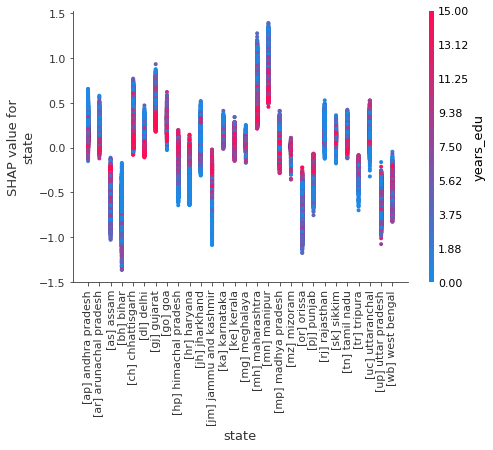

In [38]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('years_edu', 'years_edu'),
         ('years_edu', 'age'), 
         ('years_edu', 'urban'),
         ('years_edu', 'caste_sc/st'),
         ('years_edu', 'caste_general'),
         ('years_edu', 'wealth_index'),
         ('years_edu', 'no_children_below5'),
         ('years_edu', 'total_children'),
         ('hh_religion', 'years_edu'),
         ('state', 'years_edu')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'caste_sc/st'


Feature: caste_sc/st, Interaction Feature: caste_sc/st


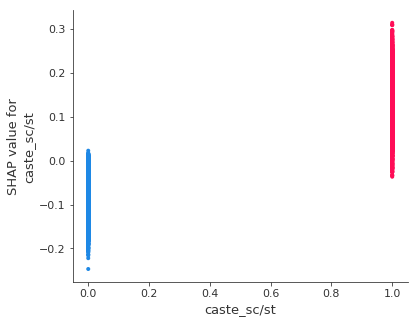


Feature: caste_sc/st, Interaction Feature: age


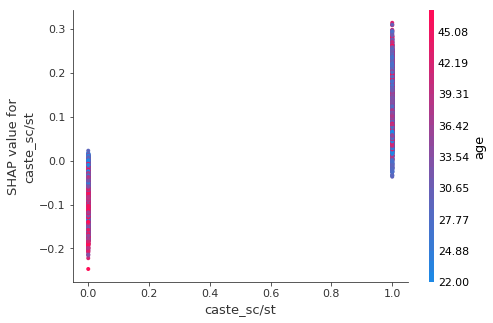


Feature: caste_sc/st, Interaction Feature: urban


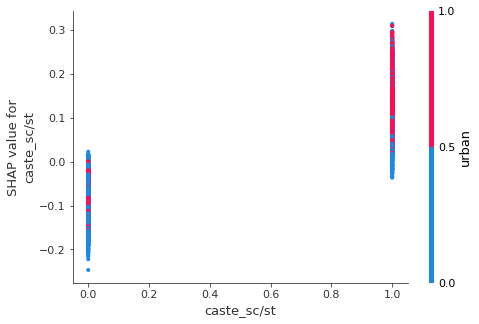


Feature: caste_sc/st, Interaction Feature: years_edu


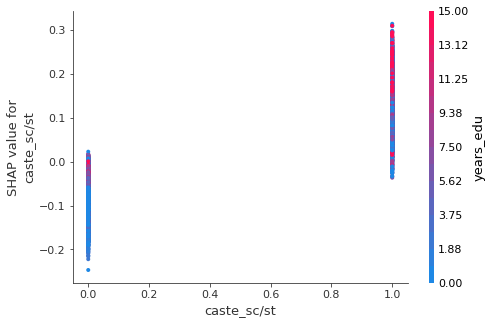


Feature: caste_sc/st, Interaction Feature: wealth_index


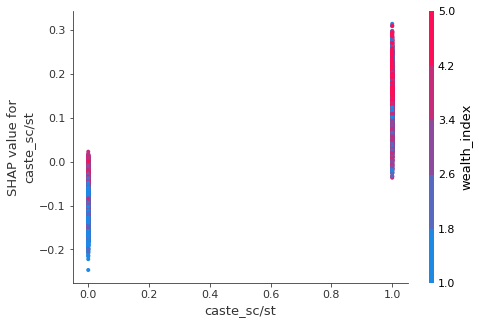


Feature: caste_sc/st, Interaction Feature: no_children_below5


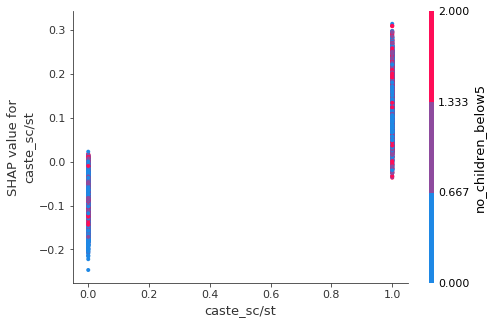


Feature: caste_sc/st, Interaction Feature: total_children


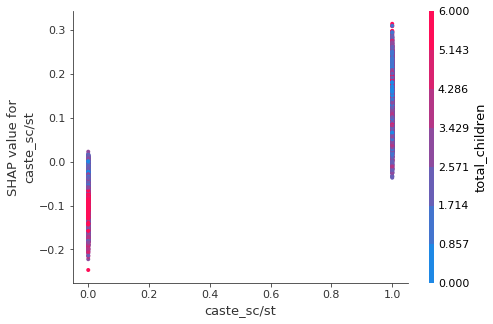


Feature: hh_religion, Interaction Feature: caste_sc/st


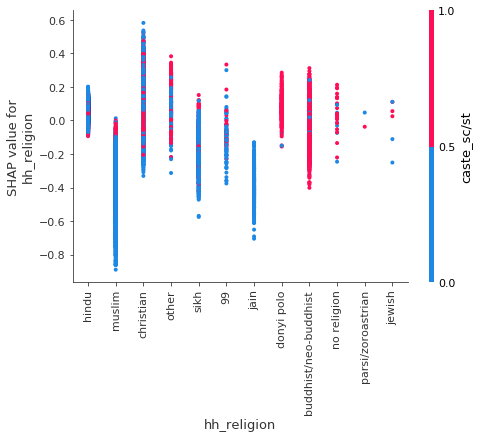


Feature: state, Interaction Feature: caste_sc/st


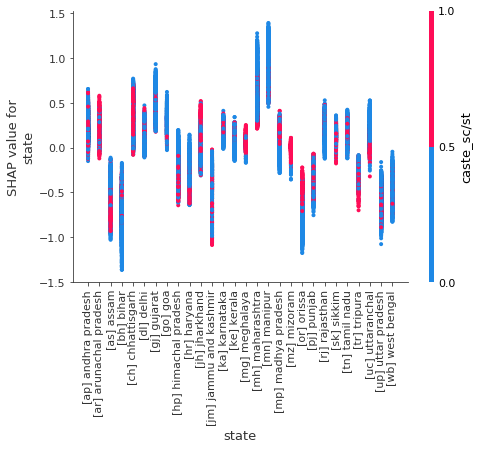

In [39]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_sc/st', 'caste_sc/st'),
         ('caste_sc/st', 'age'), 
         ('caste_sc/st', 'urban'),
         ('caste_sc/st', 'years_edu'),
         ('caste_sc/st', 'wealth_index'),
         ('caste_sc/st', 'no_children_below5'),
         ('caste_sc/st', 'total_children'),
         ('hh_religion', 'caste_sc/st'),
         ('state', 'caste_sc/st')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

#### Plots for 'caste_general'


Feature: caste_general, Interaction Feature: caste_general


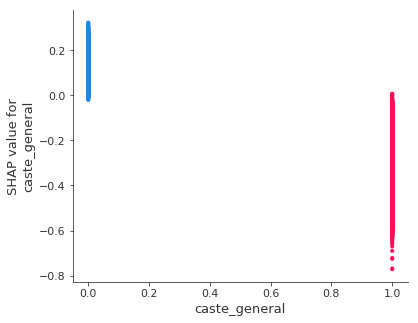


Feature: caste_general, Interaction Feature: age


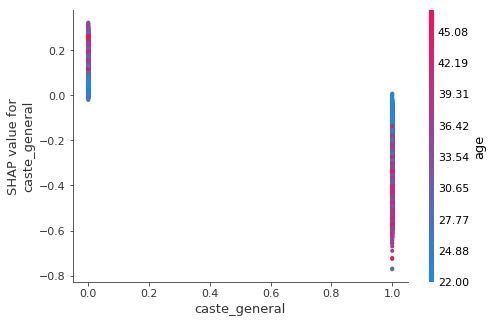


Feature: caste_general, Interaction Feature: urban


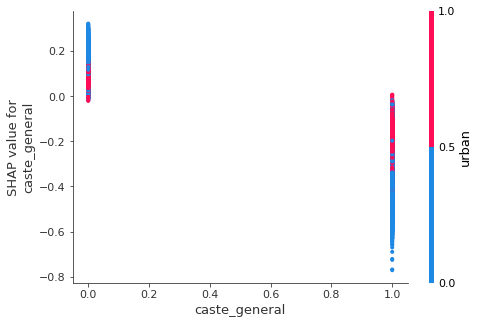


Feature: caste_general, Interaction Feature: years_edu


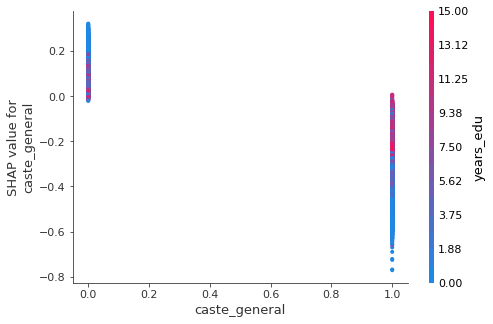


Feature: caste_general, Interaction Feature: wealth_index


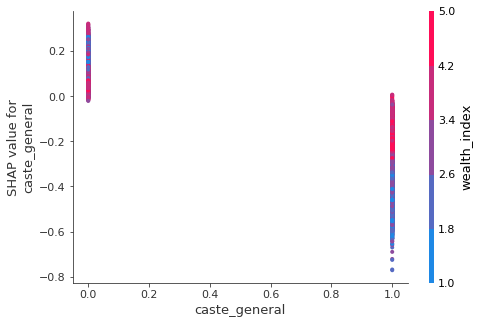


Feature: caste_general, Interaction Feature: no_children_below5


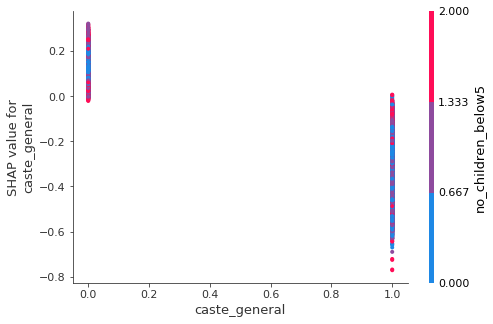


Feature: caste_general, Interaction Feature: total_children


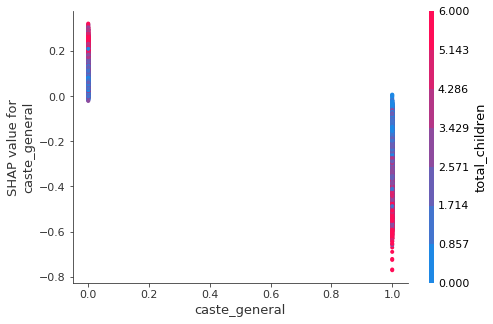


Feature: hh_religion, Interaction Feature: caste_general


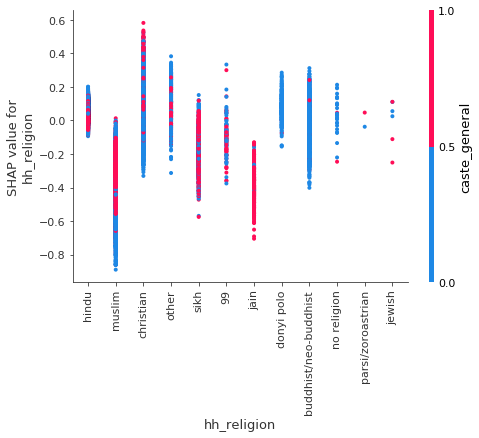


Feature: state, Interaction Feature: caste_general


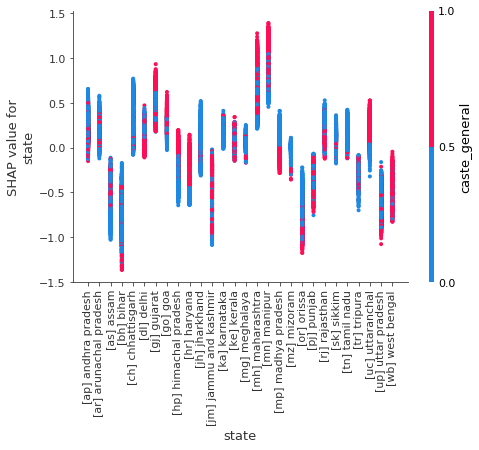

In [40]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_general', 'caste_general'),
         ('caste_general', 'age'), 
         ('caste_general', 'urban'),
         ('caste_general', 'years_edu'),
         ('caste_general', 'wealth_index'),
         ('caste_general', 'no_children_below5'),
         ('caste_general', 'total_children'),
         ('hh_religion', 'caste_general'),
         ('state', 'caste_general')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(col_name, shap_values, dataset, display_features=dataset_display, interaction_index=int_col_name)

---

# Visualizing Bar/Summary plots split by age bins


Age Range: 21 - 25 years
Sample size: 13487

state - 0.34568929157448836
hh_religion - 0.0967518522831379
urban - 0.15205378395208435
women_anemic - 0.010305644688946947
total_children - 0.17263056705701235
obese_female - 0.05699802052835487
age - 0.3012863381219946
years_edu - 0.23038497504202676
wealth_index - 0.42561588609092926
hh_members - 0.06324299611657748
no_children_below5 - 0.19708732429389544
freq_tv - 0.09849736018840065
caste_don't know - 0.0015982860980909008
caste_general - 0.13359985073899652
caste_other backward class - 0.007760068439890328
caste_sc/st - 0.05417314264782462


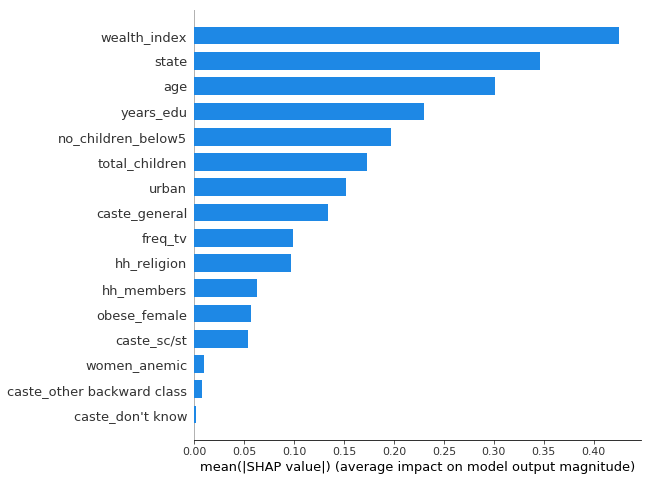

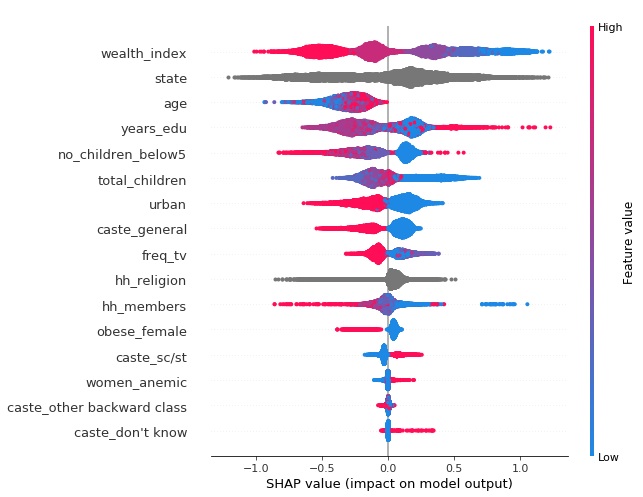


Age Range: 26 - 30 years
Sample size: 13101

state - 0.35506928636665447
hh_religion - 0.0967611913008502
urban - 0.1637805883243919
women_anemic - 0.010416130666631048
total_children - 0.08808300587024649
obese_female - 0.07992473006370879
age - 0.05263505426615591
years_edu - 0.24663304731870597
wealth_index - 0.45175720350121884
hh_members - 0.06332023875221553
no_children_below5 - 0.18974480027141447
freq_tv - 0.101117324205837
caste_don't know - 0.001738220906374368
caste_general - 0.15915325189982252
caste_other backward class - 0.010068048311347444
caste_sc/st - 0.06612084598678154


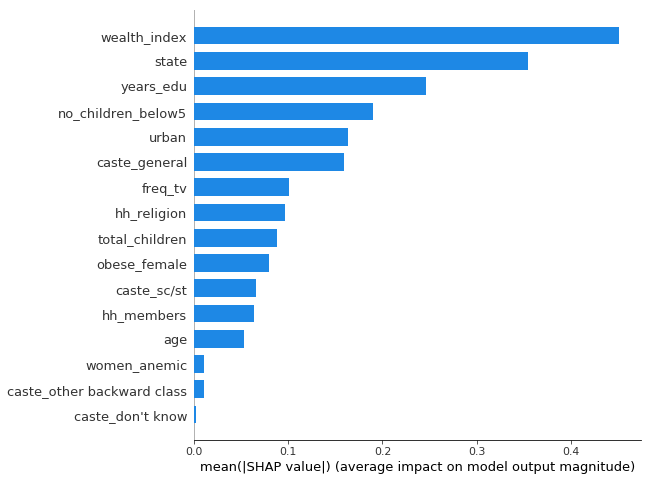

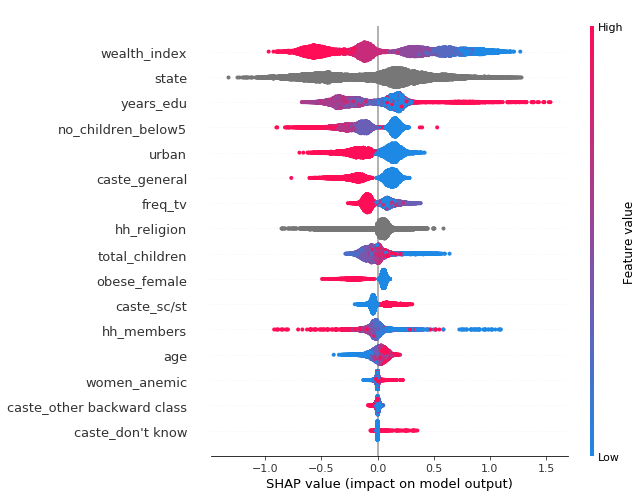


Age Range: 31 - 35 years
Sample size: 12209

state - 0.36418040118372097
hh_religion - 0.0965595801039493
urban - 0.16256877649967183
women_anemic - 0.009571539155106046
total_children - 0.0658272028520274
obese_female - 0.08757396210453883
age - 0.14497759666954363
years_edu - 0.23835184644133775
wealth_index - 0.4555765456643329
hh_members - 0.06656568319881882
no_children_below5 - 0.1602127396441039
freq_tv - 0.10491852417631634
caste_don't know - 0.0015223993338306832
caste_general - 0.18032890988727393
caste_other backward class - 0.009697574034134066
caste_sc/st - 0.06783864237783155


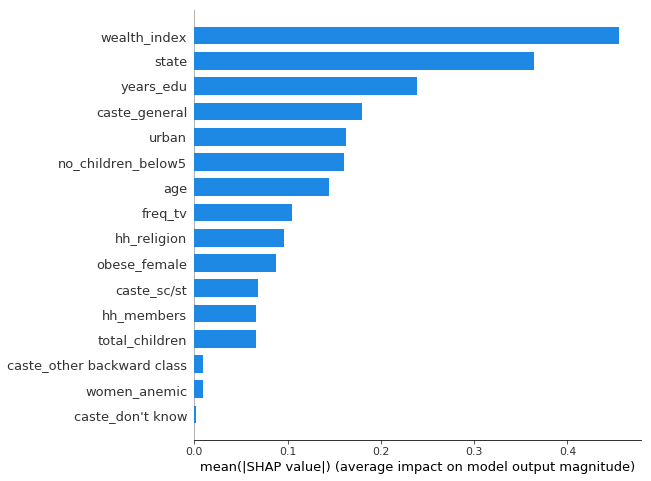

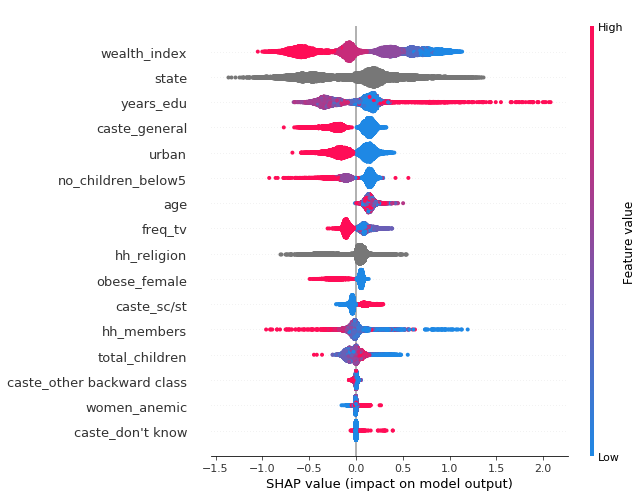


Age Range: 36 - 40 years
Sample size: 10658

state - 0.3637551737190049
hh_religion - 0.09746155779216754
urban - 0.16188357552673793
women_anemic - 0.007868981537609319
total_children - 0.05938763873512939
obese_female - 0.10215573631536061
age - 0.2157185370886883
years_edu - 0.22645265421412214
wealth_index - 0.4550881286445215
hh_members - 0.07178193108224684
no_children_below5 - 0.12845839350517566
freq_tv - 0.09634909561216255
caste_don't know - 0.0014395745750503963
caste_general - 0.17730700826517973
caste_other backward class - 0.010645160928535064
caste_sc/st - 0.06609062013413725


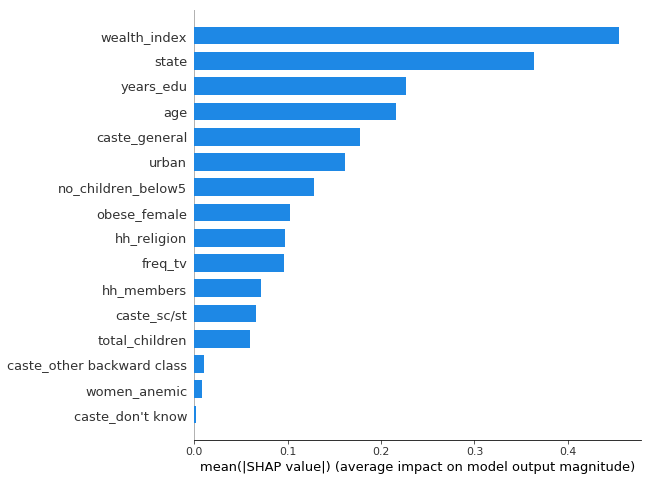

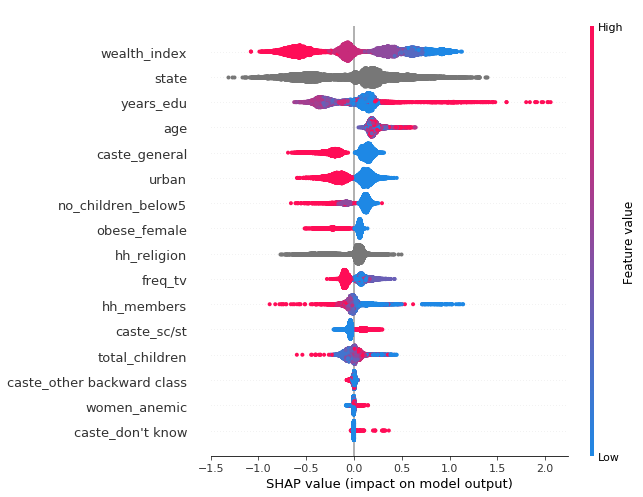


Age Range: 41 - 45 years
Sample size: 8613

state - 0.3633513554802449
hh_religion - 0.10387478574430936
urban - 0.16385228348079103
women_anemic - 0.007429064328763784
total_children - 0.05659115067552408
obese_female - 0.11099587461774099
age - 0.12085573835535425
years_edu - 0.22084104517228953
wealth_index - 0.4661317239615172
hh_members - 0.07213432655793756
no_children_below5 - 0.11302565991893486
freq_tv - 0.09826692873506068
caste_don't know - 0.0017560227425095856
caste_general - 0.18050708334288862
caste_other backward class - 0.009242078037098367
caste_sc/st - 0.06588315987375466


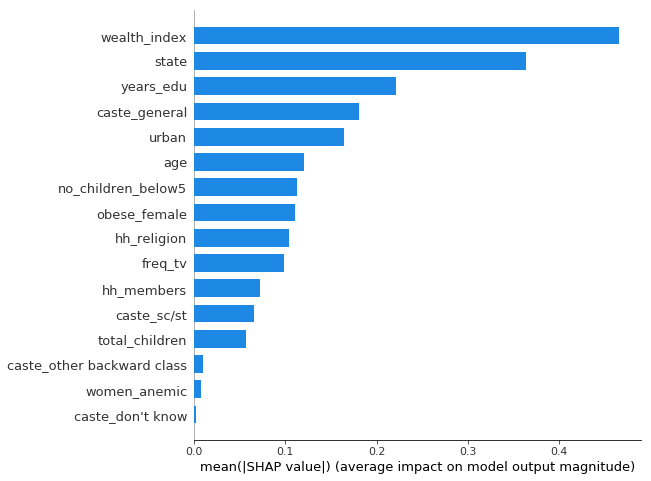

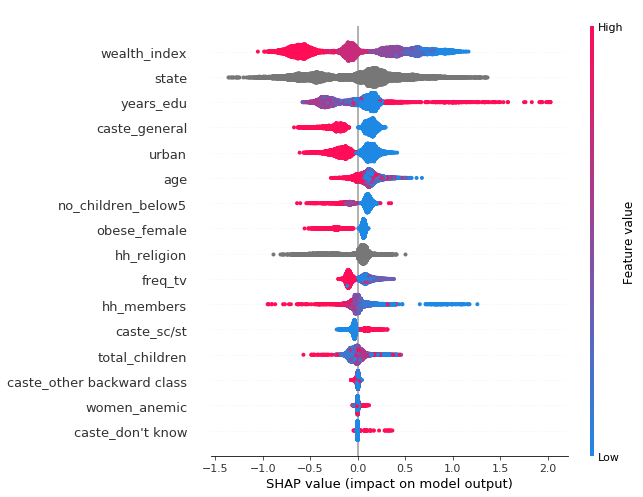


Age Range: 46 - 50 years
Sample size: 4290

state - 0.3503609666576499
hh_religion - 0.10988243099706785
urban - 0.16584900090484972
women_anemic - 0.010299581986893984
total_children - 0.053141848767207185
obese_female - 0.11006544199889817
age - 0.0842486755388691
years_edu - 0.22166169691578286
wealth_index - 0.48682572846234606
hh_members - 0.08099079688617525
no_children_below5 - 0.11290820915134087
freq_tv - 0.08008529518335823
caste_don't know - 0.0014837893267101564
caste_general - 0.18085051842491806
caste_other backward class - 0.008435266495000647
caste_sc/st - 0.06595865878853668


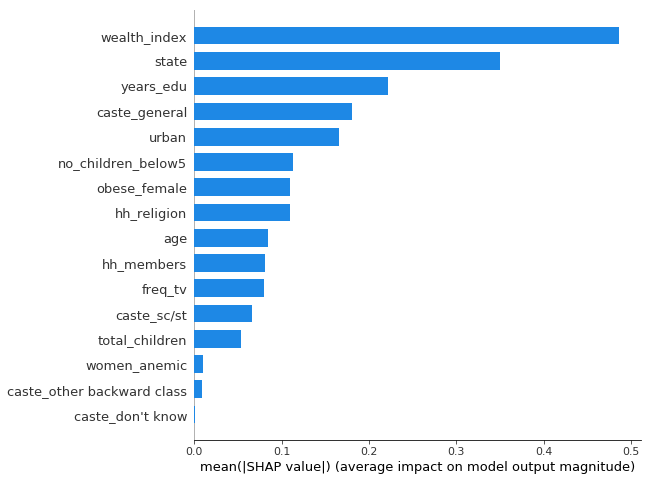

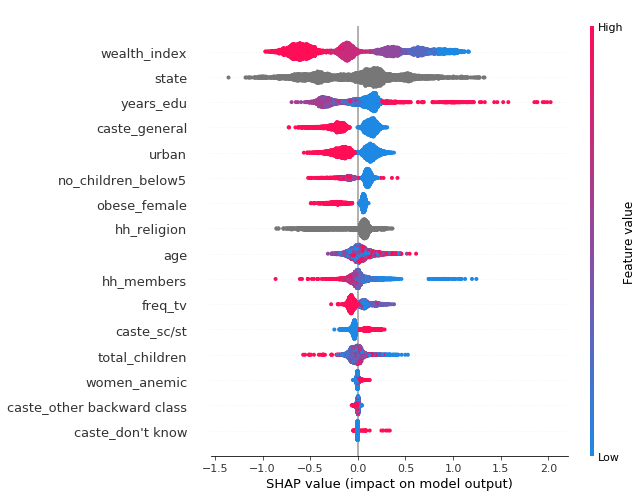

In [41]:
bins = [(21,25), (26,30), (31,35), (36,40), (41,45), (46,50)]

for low, high in bins:
    # Sample dataset by age range
    dataset_sample = dataset[(dataset.age > low) & (dataset.age <= high)]
    dataset_display_sample = dataset_display[(dataset.age > low) & (dataset.age <= high)]
    targets_sample = targets[(dataset.age > low) & (dataset.age <= high)]
    shap_values_sample = shap_values[(dataset.age > low) & (dataset.age <= high)]
    
    print("\nAge Range: {} - {} years".format(low, high))
    print("Sample size: {}\n".format(len(dataset_sample)))
    
    for col, sv in zip(dataset_sample.columns, np.abs(shap_values_sample).mean(0)):
        print(f"{col} - {sv}")
    
    # Summary plots
    shap.summary_plot(shap_values_sample, dataset_sample, plot_type="bar")
    shap.summary_plot(shap_values_sample, dataset_display_sample)

---

### SHAP Interaction Values

SHAP interaction values are a generalization of SHAP values to higher order interactions. 

The model returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. The main effects are similar to the SHAP values you would get for a linear model, and the interaction effects captures all the higher-order interactions are divide them up among the pairwise interaction terms. 

Note that the sum of the entire interaction matrix is the difference between the model's current output and expected output, and so the interaction effects on the off-diagonal are split in half (since there are two of each). When plotting interaction effects the SHAP package automatically multiplies the off-diagonal values by two to get the full interaction effect.

In [42]:
# Sample from dataset based on sample weights
dataset_ss = dataset.sample(10000, weights=sample_weights, random_state=random_state)
print(dataset_ss.shape)
dataset_display_ss = dataset_display.loc[dataset_ss.index]
print(dataset_display_ss.shape)

(10000, 16)
(10000, 16)


In [43]:
# Compute SHAP interaction values (time consuming)
# shap_interaction_values = explainer.shap_interaction_values(dataset_ss)
shap_interaction_values = pickle.load(open(f'res/{target_col}-{year}-shapints.obj', 'rb'))

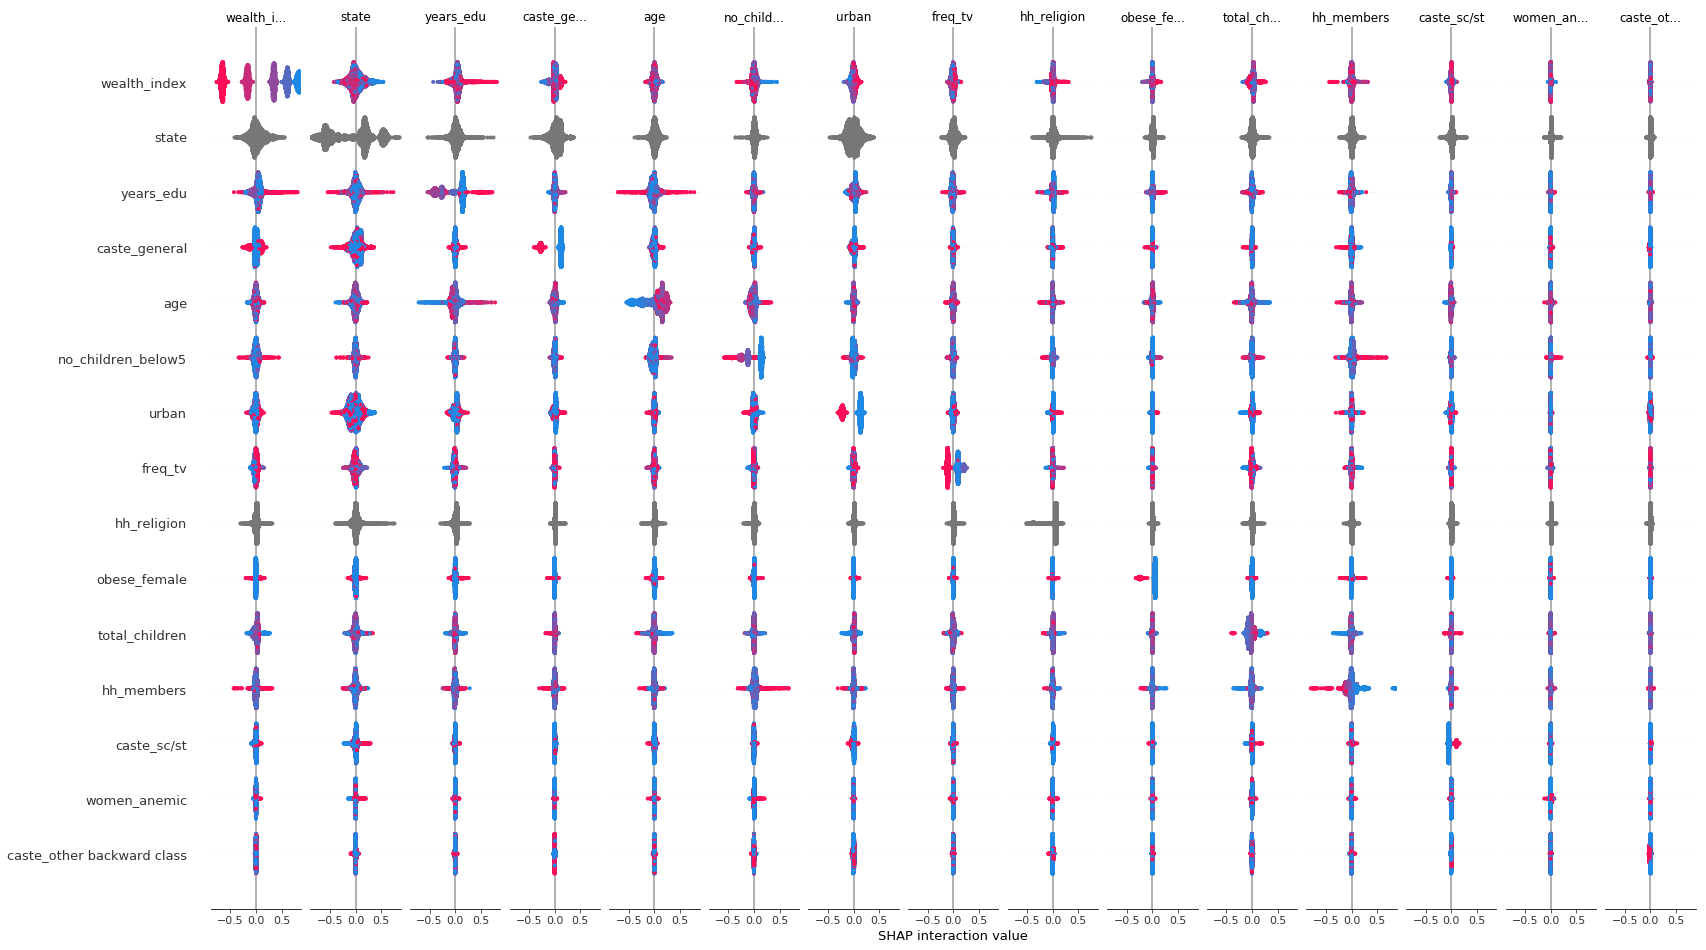

In [44]:
shap.summary_plot(shap_interaction_values, dataset_display_ss, max_display=15)

### Heatmap of SHAP Interaction Values

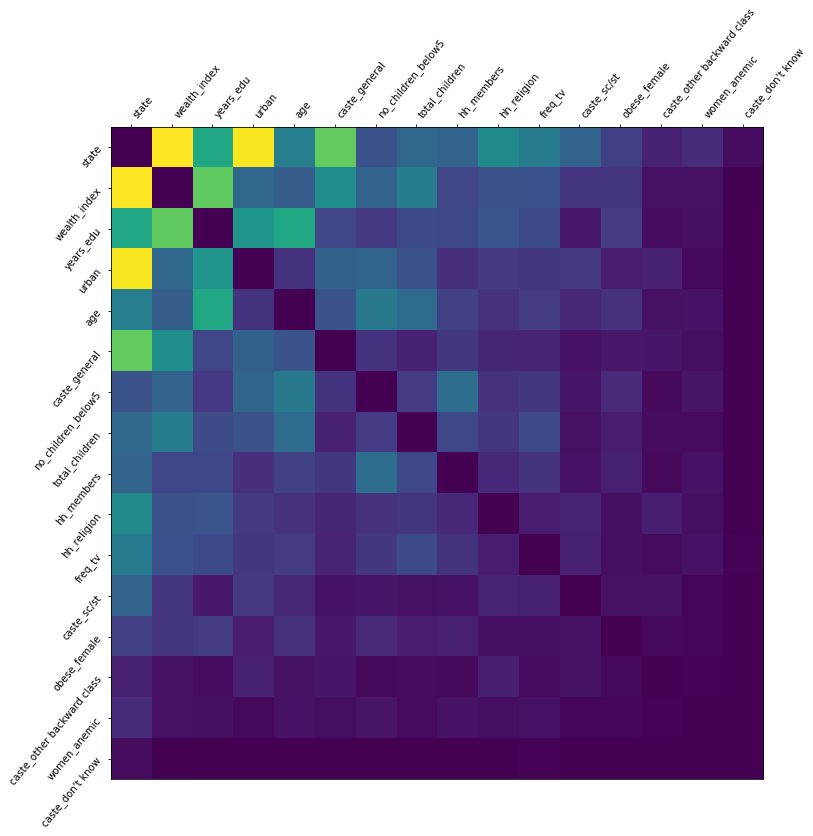

In [45]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), dataset_ss.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), dataset_ss.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

### SHAP Interaction Value Dependence Plots

Running a dependence plot on the SHAP interaction values a allows us to separately observe the main effects and the interaction effects.

Below we plot the main effects for age and some of the interaction effects for age. It is informative to compare the main effects plot of age with the earlier SHAP value plot for age. The main effects plot has no vertical dispersion because the interaction effects are all captured in the off-diagonal terms.

**Good example of how to infer interesting stuff from interaction values: https://slundberg.github.io/shap/notebooks/NHANES%20I%20Survival%20Model.html**

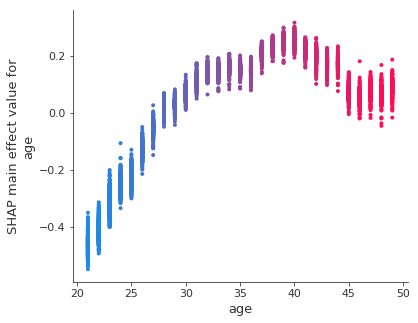

In [46]:
shap.dependence_plot(
    ("age", "age"), 
    shap_interaction_values, dataset_ss, display_features=dataset_display_ss
)

Now we plot the interaction effects involving age (and other features after that). These effects capture all of the vertical dispersion that was present in the original SHAP plot but is missing from the main effects plot above.

#### Plots for 'age'


Feature: age, Interaction Feature: age


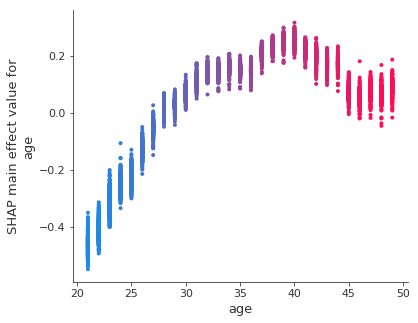


Feature: age, Interaction Feature: urban


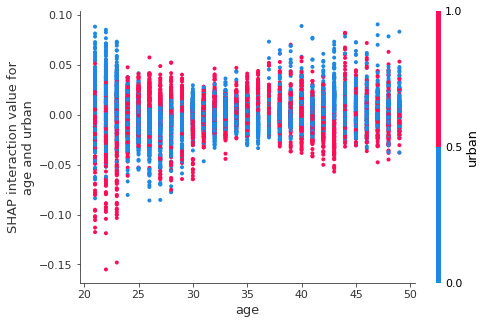


Feature: age, Interaction Feature: caste_sc/st


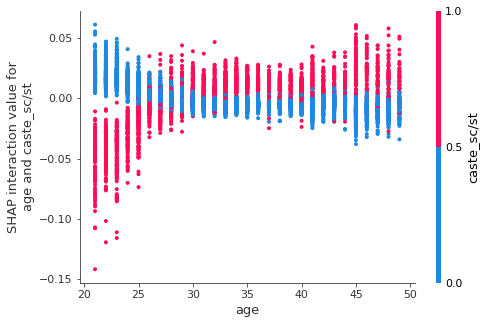


Feature: age, Interaction Feature: caste_general


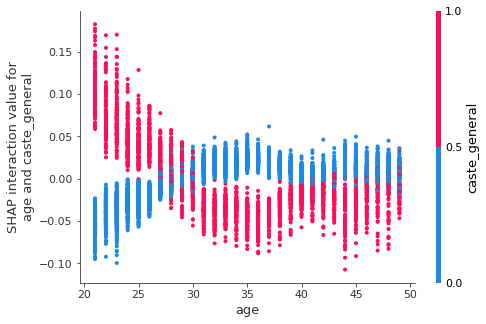


Feature: age, Interaction Feature: wealth_index


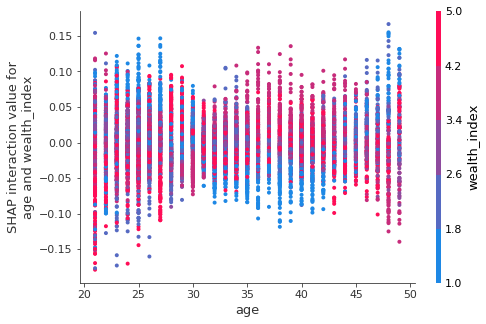


Feature: age, Interaction Feature: years_edu


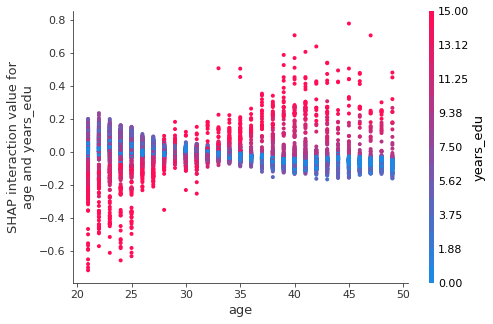


Feature: age, Interaction Feature: no_children_below5


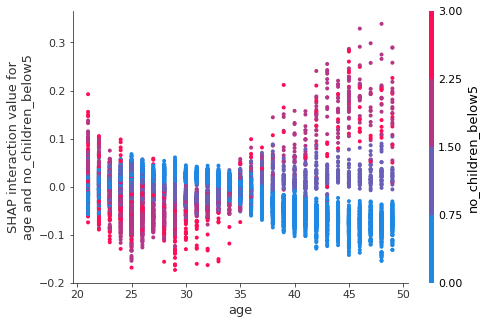


Feature: age, Interaction Feature: total_children


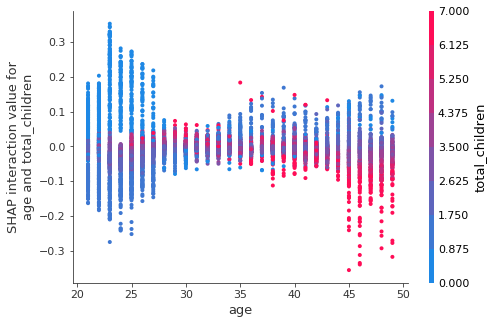

In [47]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('age', 'age'),
         ('age', 'urban'),
         ('age', 'caste_sc/st'),
         ('age', 'caste_general'),
         ('age', 'wealth_index'),
         ('age', 'years_edu'),
         ('age', 'no_children_below5'),
         ('age', 'total_children')]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'wealth_index'


Feature: wealth_index, Interaction Feature: wealth_index


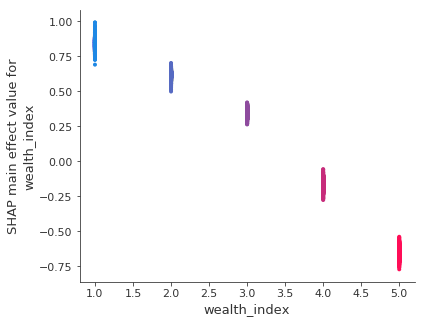


Feature: wealth_index, Interaction Feature: age


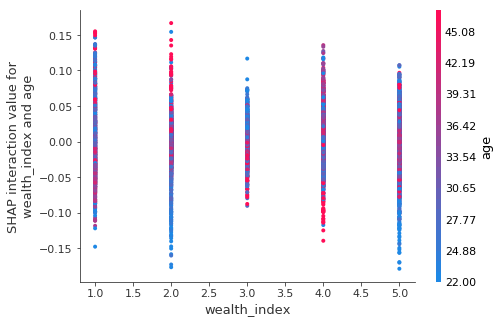


Feature: wealth_index, Interaction Feature: urban


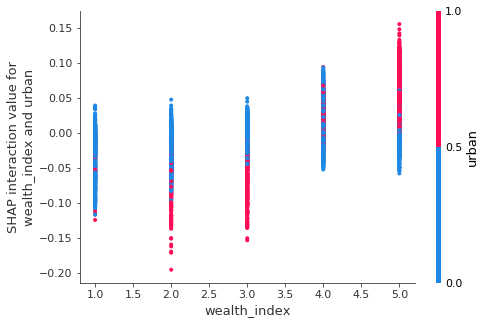


Feature: wealth_index, Interaction Feature: caste_sc/st


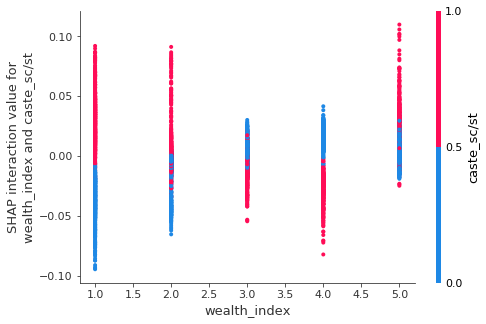


Feature: wealth_index, Interaction Feature: caste_general


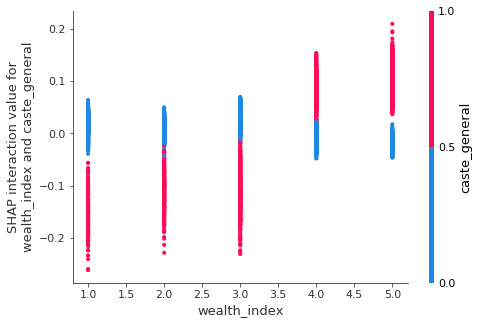


Feature: wealth_index, Interaction Feature: years_edu


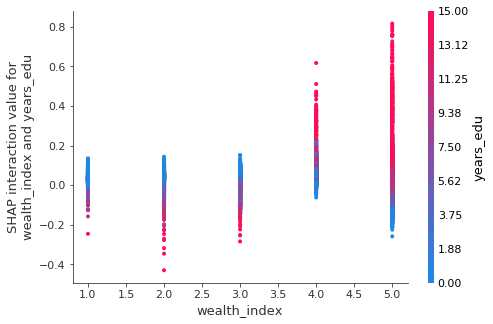


Feature: wealth_index, Interaction Feature: no_children_below5


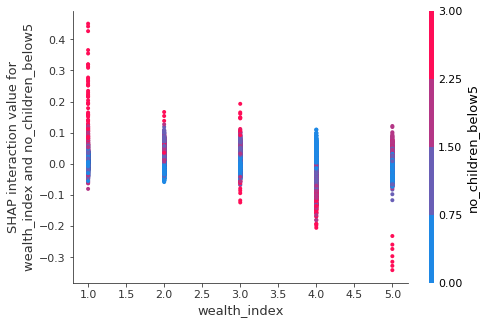


Feature: wealth_index, Interaction Feature: total_children


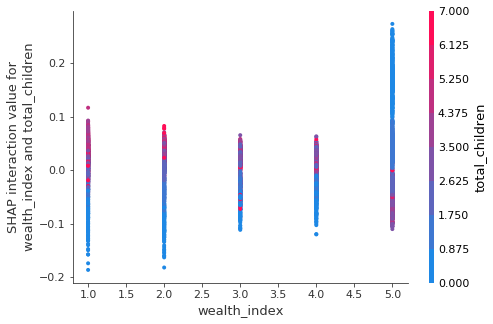

In [48]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('wealth_index', 'wealth_index'),
         ('wealth_index', 'age'), 
         ('wealth_index', 'urban'),
         ('wealth_index', 'caste_sc/st'),
         ('wealth_index', 'caste_general'),
         ('wealth_index', 'years_edu'),
         ('wealth_index', 'no_children_below5'),
         ('wealth_index', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'years_edu'


Feature: years_edu, Interaction Feature: years_edu


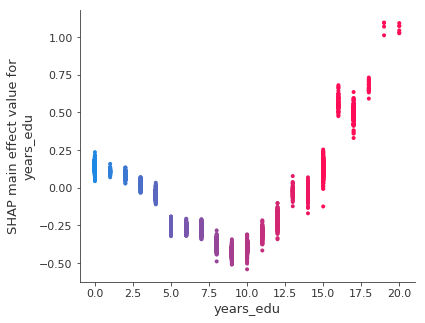


Feature: years_edu, Interaction Feature: age


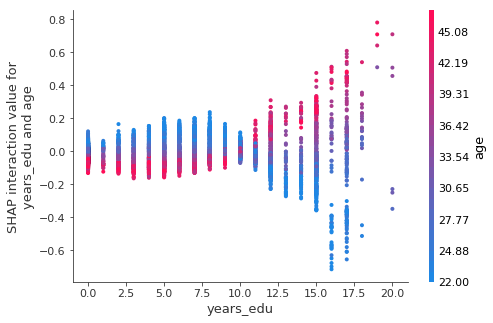


Feature: years_edu, Interaction Feature: urban


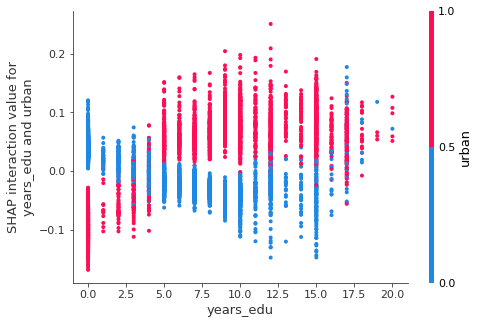


Feature: years_edu, Interaction Feature: caste_sc/st


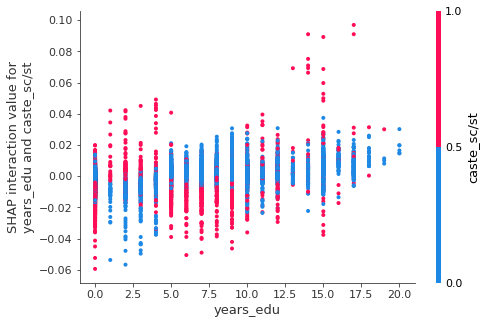


Feature: years_edu, Interaction Feature: caste_general


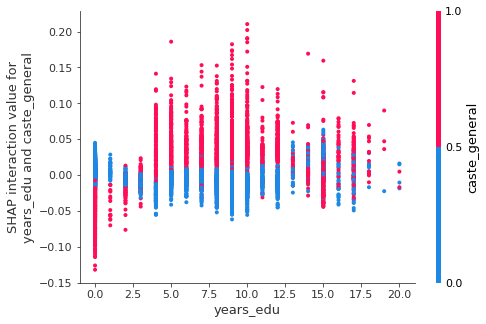


Feature: years_edu, Interaction Feature: wealth_index


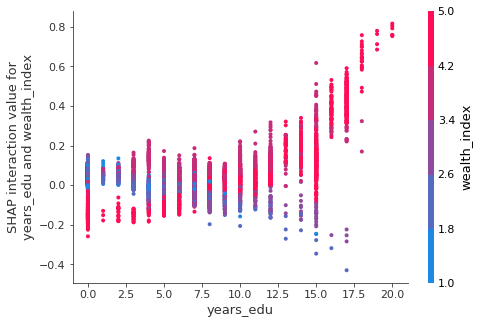


Feature: years_edu, Interaction Feature: no_children_below5


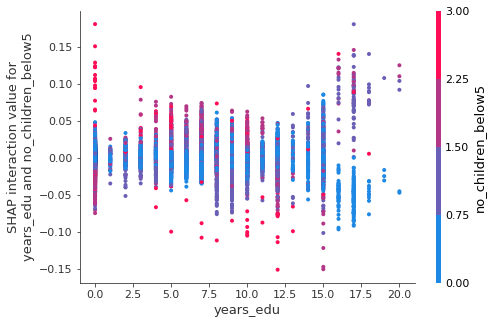


Feature: years_edu, Interaction Feature: total_children


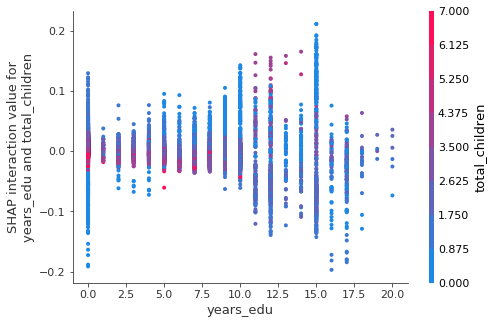

In [49]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('years_edu', 'years_edu'),
         ('years_edu', 'age'), 
         ('years_edu', 'urban'),
         ('years_edu', 'caste_sc/st'),
         ('years_edu', 'caste_general'),
         ('years_edu', 'wealth_index'),
         ('years_edu', 'no_children_below5'),
         ('years_edu', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'caste_sc/st'


Feature: caste_sc/st, Interaction Feature: caste_sc/st


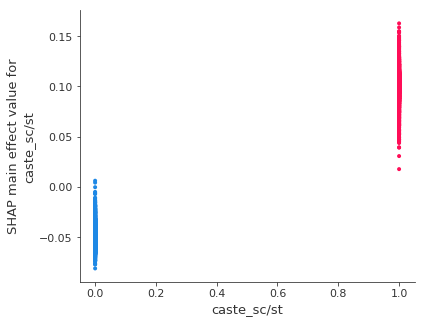


Feature: caste_sc/st, Interaction Feature: age


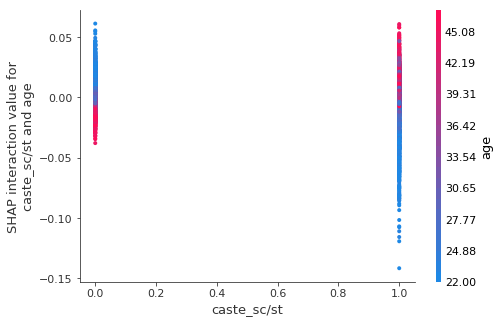


Feature: caste_sc/st, Interaction Feature: urban


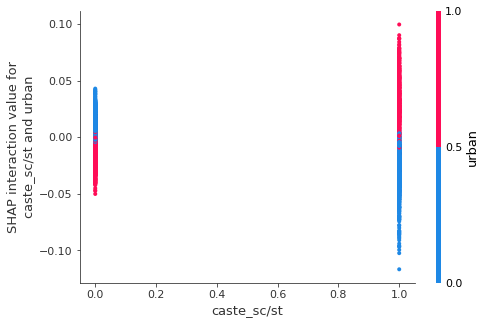


Feature: caste_sc/st, Interaction Feature: years_edu


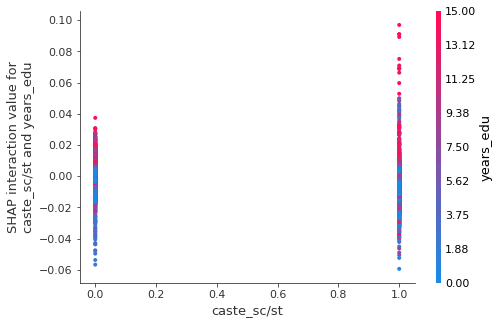


Feature: caste_sc/st, Interaction Feature: wealth_index


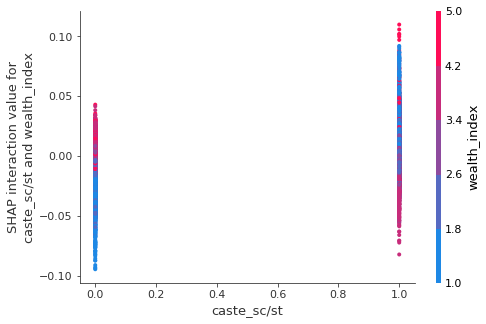


Feature: caste_sc/st, Interaction Feature: no_children_below5


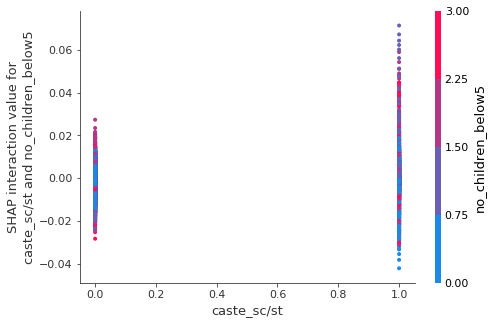


Feature: caste_sc/st, Interaction Feature: total_children


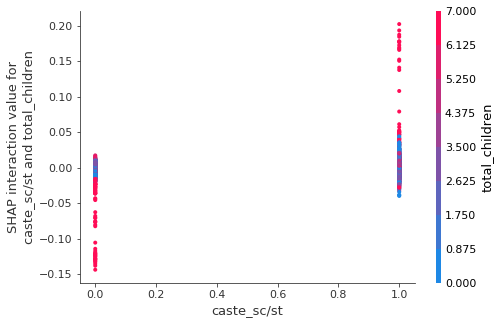

In [50]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_sc/st', 'caste_sc/st'),
         ('caste_sc/st', 'age'), 
         ('caste_sc/st', 'urban'),
         ('caste_sc/st', 'years_edu'),
         ('caste_sc/st', 'wealth_index'),
         ('caste_sc/st', 'no_children_below5'),
         ('caste_sc/st', 'total_children')
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )

#### Plots for 'caste_general'


Feature: caste_general, Interaction Feature: caste_general


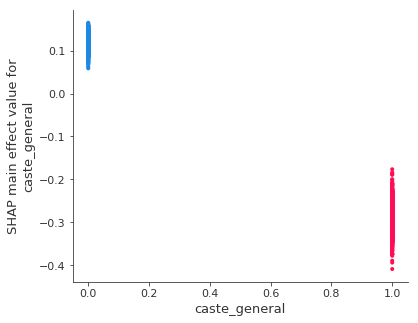


Feature: caste_general, Interaction Feature: age


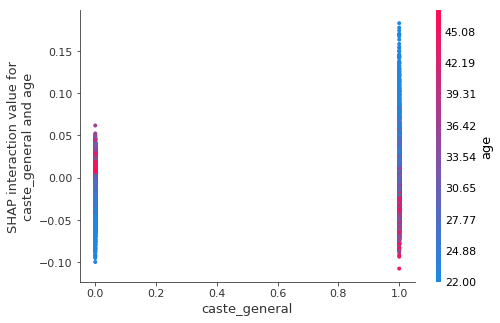


Feature: caste_general, Interaction Feature: urban


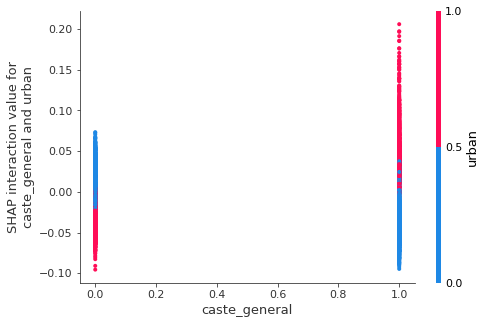


Feature: caste_general, Interaction Feature: years_edu


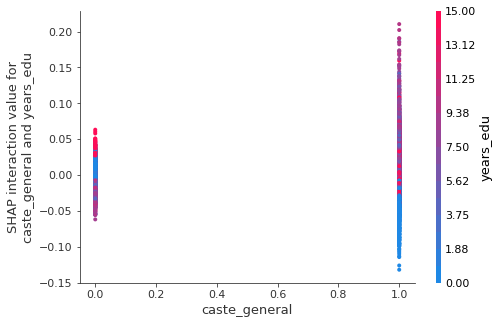


Feature: caste_general, Interaction Feature: wealth_index


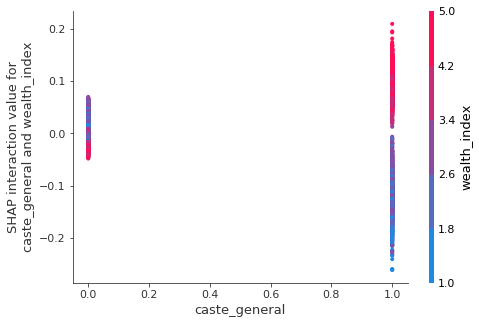


Feature: caste_general, Interaction Feature: no_children_below5


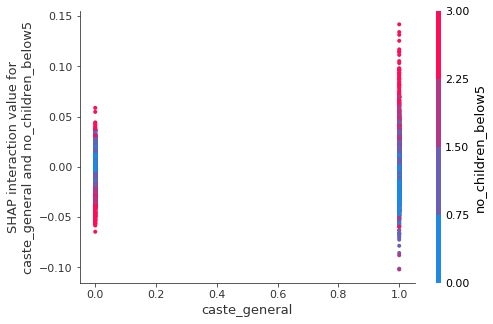


Feature: caste_general, Interaction Feature: total_children


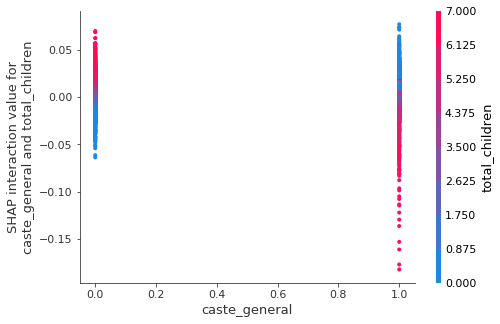

In [51]:
# Define pairs of features and interaction indices for dependence plots
pairs = [('caste_general', 'caste_general'),
         ('caste_general', 'age'), 
         ('caste_general', 'urban'),
         ('caste_general', 'years_edu'),
         ('caste_general', 'wealth_index'),
         ('caste_general', 'no_children_below5'),
         ('caste_general', 'total_children'),
        ]

# Dependence plots between pairs
for col_name, int_col_name in pairs:
    print(f"\nFeature: {col_name}, Interaction Feature: {int_col_name}")
    shap.dependence_plot(
        (col_name, int_col_name), 
        shap_interaction_values, dataset_ss, display_features=dataset_display_ss
    )